# Udacity Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines** 
***
The goal of this project is to highligh lane lines in a number of still images and short videos. This is achived with an image processing pipline. This pipline used here closesly follows the predvious lessons in the SDCEN program and includes the following processing steps:

    * Yellow and white color selection through minimum RGB thresholds
    * Grayscale
    * guassian blur
    * Canny Edge Detection
    * Area of Intrest Masking
    * Huge line transform line detection
    * Line slope categorization, averaging, and extrapolation

***
The finished pipline identifies lane lines in the example still pictures and videos similar to the included examples.


## Import Packages
** Step one is importing some packages. Here are the ones from the lessons, plus a few extras.**

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
import math
%matplotlib inline

# for the movies
from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Reading in Images
***
To get started, I used a function from https://github.com/naokishibuya/car-finding-lane-lines, labeled 
source [1]. The function includes an option for cmap, and some hard coded parameters to 
plot the 6 test images in a reasonable way using plt.imshow and plt.tight_layout.
***

***
There are a few things that may cause difficulties off the bat: bright white objects, such as
the a car that are not lane lines, some slightly yellow horizontal lines that may make it through some
of the processing steps, etc. 
***

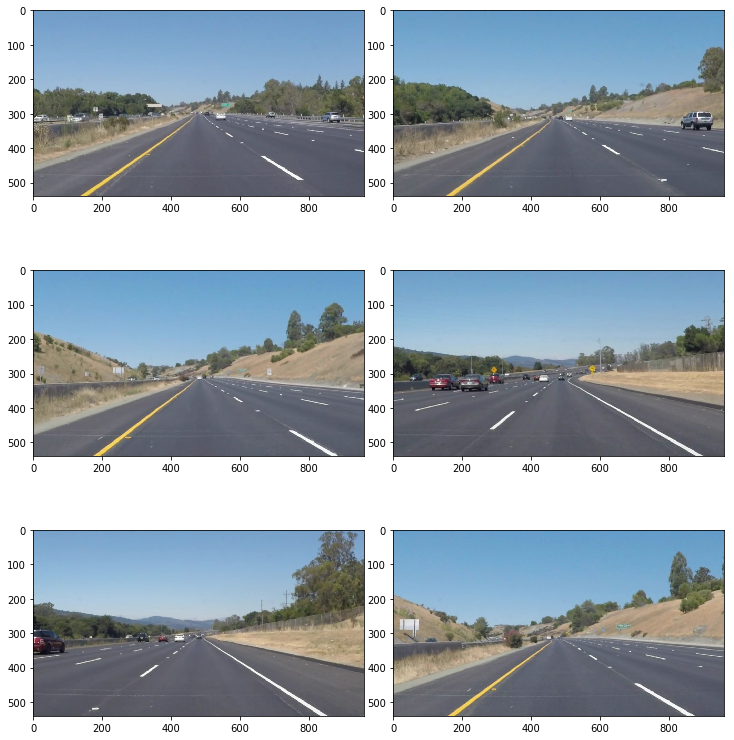

In [3]:
#reading in an image
image = cv2.imread('test_images/solidWhiteRight.jpg')

# The plotting function, I've modified it to show the x and y axis
# source [1]
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

# Read in and plot all test images, adapted from source [1]
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
show_images(test_images)

## Processing functions

***
Here are the processing functions used to build the pipline to identify the lanes. There are a 
combination of the helper functions, information from the lesson, source [1], and my own tuning
and edits. 
***

In [4]:
#=============================================================
# functions required for pipline

# convert to grayscale, call plt.imshow(gray, cmap='gray') to plot.
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# canny edge detection low high thresholds likely between 0 and 200, roughly 100 or so apart
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# blur to highlight straight lines, kernel size is positie and odd number. try 5 - 25
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# ROI mask veritices is a np.array, using dimentions from lesson  
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img):
    lines = cv2.HoughLinesP(img, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap=300)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# runs the hough lines function, but returns output of hughLinesP, rather than an image composite overlay
def hough_lines(img):
    lines = cv2.HoughLinesP(img, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap=300)

# get a list of lines drawn by the cv2.HoughLinesP function
def get_lines(img):
    lines = cv2.HoughLinesP(img, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap=300)
    return lines

# Python 3 has support for cool math symbols. cool. 
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

    
#=============================================================
# adapted from source [1]
# includes hough transform slope and intercept averaging
# and extrapolation using image shape

def simple_lines(image, line_image):
    
    lines = get_lines(line_image)
    # initilize emtpy objects
    left_slopes = []
    left_int = [] 
    right_slopes = [] 
    right_int = [] 
    
    # fill in the right and left lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2 - y1)/(x2 - x1)
            intercept = y1 - slope * x1
            # test for right or left line by slope sign
            if slope < 0: 
                left_slopes.append(slope)
                left_int.append(intercept)
            else:
                right_slopes.append(slope)
                right_int.append(intercept)

    # average all slopes and intercepts for each side     
    left_lane = (np.mean(left_slopes), np.mean(left_int))
    right_lane = (np.mean(right_slopes), np.mean(right_int))

    # hard coded y vlaues, only work on these images
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6 # middlish
    
    # for left line
    slope, intercept = left_lane
    
    # incase of Nan 
    if math.isnan(slope):
        return [9999]
    if math.isnan(intercept):
        return [9999]
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    left_line = ((x1, y1), (x2, y2))
    
    # for right line
    slope, intercept = right_lane
    
    # incase of Nan 
    if math.isnan(slope):
        return [9999]
    if math.isnan(intercept):
        return [9999]
    
    # change to integers
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    
    right_line = ((x1, y1), (x2, y2))
    
    return left_line, right_line

# source [1]
def select_rgb_white_yellow(image): 
    # define thresholds
    lower = np.uint8([220, 220, 220])
    upper = np.uint8([255, 255, 255])
    
    # apply white mask
    white_mask = cv2.inRange(image, lower, upper)
    
    # define thresholds
    lower = np.uint8([200, 200,   0])
    upper = np.uint8([255, 255, 255])
    
    # apply yellow mask
    yellow_mask = cv2.inRange(image, lower, upper)
    
    # combine the masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    
    return masked

# source [1]
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line != 9999:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

## Testing the pipeline on the provided images

**Here,the pipeline was tested and iterated until a reasonalbe group of parameters
and function structures was achieved. Parameters included white and yellow thresholds around 200, 
gussian kernel size (15), Canny edge detection low (50) and high (150) thresholds, ROI verticies, 
I used a triangle as in the lesson, hough transform parameters (used source [1]) 
and image composite mixing parameters for final output**

**The color detection step proved to be difficutl, as color was a very important feature in idenifying lane lines, but could vary between examples and the limitation of a simple low threshold became apparent quickly. For example, other under different
light conditions the color lane lines may be more or less similar to nearby surrounding objects, making different threshold values optimum for different images.**

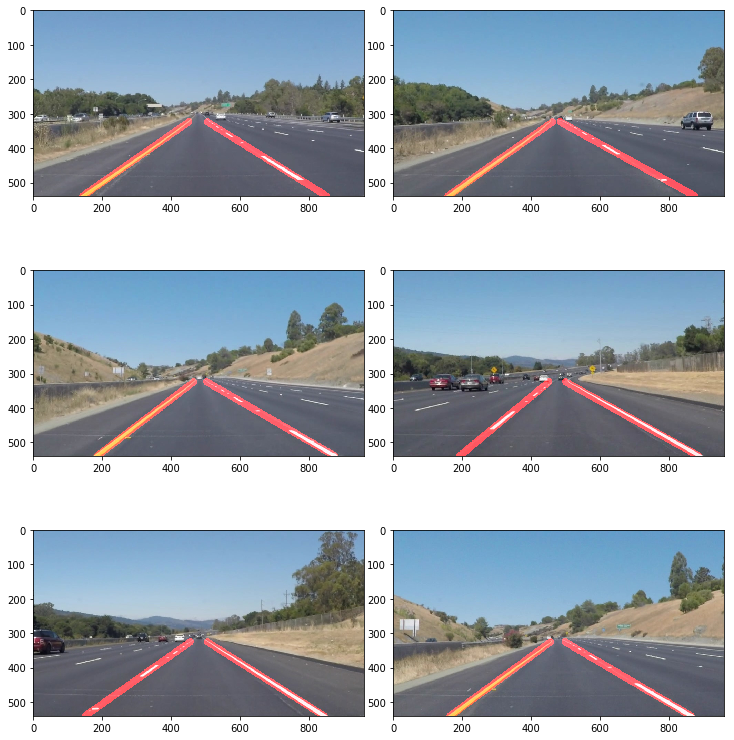

In [6]:
# put all together for the pipeline
def detect_lines(img):
    img1 = select_rgb_white_yellow(img) # source [1]
    img2 = grayscale(img1)
    img3 = gaussian_blur(img2, kernel_size = 19)
    img4 = canny(img3, 50, 150)
    
    # define the roi extents
    left_bottom = [0, 539]
    right_bottom = [900, 539]
    apex = [475, 320]
    vertices = np.array([[left_bottom, right_bottom, apex]], dtype=np.int32)
    
    # cut image to roi
    img_roi = region_of_interest(img4, vertices)
    
    # hough line transform, and averaging and extrapolaiton
    # does not output an image
    input_lines = simple_lines(img, img_roi)
    
    # draw the new lines over the original image
    img6 = draw_lane_lines(img, input_lines)
    return img6

# source [1]
show_images(list(map(detect_lines, test_images)))

# Testing on Movie files

**The pipeline was tested on the movie files. Below is the white lines movie. The pipeline works, though is a bit shaky. Some other solutions to this problem employed weighted slope averaging, which could smooth out the identification between frames.**

**Code for movie loading, calling the processing function, and dispay are from the lesson**

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detect_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 50.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.64 s, sys: 240 ms, total: 3.88 s
Wall time: 4.86 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Testing on the white and yellow lines moive 

**The pipeline performs worse on the yellow and white lines movie, with a few visible 
missclassifications of roadside pixles as components of lane lines. Overall it still
identifies lanes well, however, near perfect accuracy is needed for an application 
like this. Further parameter tuning would improve performance, however, it is unlikey 
that this particular logic pipeline will generalize well to other road conditions, 
even if tuned well to the movie examples given in this project.**


In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(2,3)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(detect_lines)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:12<00:00, 52.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.3 s, sys: 536 ms, total: 11.8 s
Wall time: 13.4 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Conclusion

**The pipeline is able to identify the lane lines in both the still images and the 
movie clips. The essential problem of classifying lane line in images or a series of 
images is achived with a reasonably high accuracy. However, self driving cars require
very accurate technology, and this pipline is unlikely to perform well enough for any SDC
application. The pipeline of manually selected features which are used to identify lane
lines has major pitfalls. During the tuning process, it became clear that the classification
could fail on reletively simple cases, such as a white car at the edge of the area of 
interest, or yellow plant on the side of the road. These problems could be solved with 
further tuning and creating a complex manually defined logic pipeline to improve performance
and reliablility, however, adding logic will slow down the classifier and create oopportunities 
for bugs and faillures. For example, if it is raining, the color profile may change, 
causing the yellow and white thresholds to fail. A more robust solution with fast process
time, such as a neural net would be preferable to the pipline designed here, but would
require labeled data, where as this pipeline does not.**